# Setup a game

In [1]:
from ConnectN import ConnectN

game_setting = {'size':(3,3), 'N':3}
game = ConnectN(**game_setting)

In [2]:
print(game.move((0,1))) #initial player is +1 and if move is successful, then switch player else don't switch player
print(game.state)
print(game.player)
print(game.score)
print(game.available_moves())

True
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-1
None
[[0 0]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]


In [3]:
# player -1 move
game.move((0,0))
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1)) #won't switch players as game is over with this move

print(game.state)
print(game.player)
print(game.score)
print(game.last_move)

[[-1.  1.  0.]
 [-1.  1.  0.]
 [ 0.  1.  0.]]
1
1
(2, 1)


In [4]:
game = ConnectN(**game_setting)
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1))
# player -1 move
game.move((0,0))
# player +1 move
#game.move((0,1))
game.move((2,2))
# player -1 move
game.move((2,0))

print('Game state:\n{}'.format(game.state))
print('Last Player {}'.format(game.player))

#Note: the final game score is always from player +1's perspective. So if player +1 wins, then the score is +1, and
#if player -1 wins, then the score will be -1, i.e. player +1 has lost. And if it's a draw, then scorre is 0.
print('Final Game Score {}'.format(game.score))
print('Last Move {}'.format(game.last_move))

Game state:
[[-1.  0.  0.]
 [-1.  1.  0.]
 [-1.  1.  1.]]
Last Player -1
Final Game Score -1
Last Move (2, 0)


# Play a game interactively

<IPython.core.display.Javascript object>


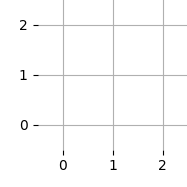

In [5]:
% matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Initialize an AI to play the game
We need to define a policy for tic-tac-toe, that takes the game state as input, and outputs a policy and a critic

## Tentative Exercise:
Code up your own policy for training

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np
import random


class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
        
        # solution
        self.conv = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        self.size = 2*2*16
        self.fc = nn.Linear(self.size,32)

        # layers for the policy
        self.fc_action1 = nn.Linear(32, 16)
        self.fc_action2 = nn.Linear(16, 9)
        
        # layers for the critic
        self.fc_value1 = nn.Linear(32, 8)
        self.fc_value2 = nn.Linear(8, 1)
        self.tanh_value = nn.Tanh()
        
        
    def forward(self, x):

        
        # solution
        y = F.relu(self.conv(x))
        y = y.view(-1, self.size)
        y = F.relu(self.fc(y))
        
        
        # the action head
        a = F.relu(self.fc_action1(y))
        a = self.fc_action2(a)
        
        # availability of moves
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.view(-1, 9)
        
        # locations where actions are not possible, we set the prob to zero
        maxa = torch.max(a)
        # subtract off max for numerical stability (avoids blowing up at infinity)
        exp = avail*torch.exp(a-maxa)  # locations where actions are not possible, we set the prob to zero
        prob = exp/torch.sum(exp)
        
        
        # the value head
        value = F.relu(self.fc_value1(y))
        value = self.tanh_value(self.fc_value2(value))
        return prob.view(3,3), value
        

policy = Policy()


## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$.

For normal MCTS, T=0. But during training, for better exploration, T is set near 1.

In [7]:
import MCTS

from copy import copy
import random

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(50):
        mytree.explore(policy)
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    return mytreenext.game.last_move

def Policy_Player_MCTS_debug_only(game):
    mytree = MCTS.Node(copy(game))
    endofexplore_tree_depth_list = []
    selection_tree_depth_list = []
    for _ in range(500):
        d_, d = mytree.explore(policy) #will fail as have commented out the return stuff for debug
        endofexplore_tree_depth_list.append(d)
        selection_tree_depth_list.append(d_)
    print(endofexplore_tree_depth_list)
    print(selection_tree_depth_list)
    for jj in range(0,5):
        print('{}: Tree Depth at End of Explore is {} and Tree Depth During Selection is {}'.format(jj, sum((np.array(endofexplore_tree_depth_list) == jj)), \
            sum((np.array(selection_tree_depth_list) == jj))))
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
    
    
def Random_Player(game):
    return random.choice(game.available_moves())    

def Policy_Player_No_MCTS(game):
    frame=torch.tensor(game.state*game.player, dtype=torch.float, device='cpu')
    input_=frame.unsqueeze(0).unsqueeze(0)
    prob, v = policy(input_)
    mask_np = game.available_mask()
    #print(prob)
    #print(mask_np)
    #mask_np[1,1]=0
    prob_np = prob.detach().numpy()
    next_move = np.unravel_index(np.argmax(prob_np*mask_np, axis=None), prob_np.shape)
    
    return next_move

In [8]:
game = ConnectN(**game_setting)
#print(game.state)
Policy_Player_MCTS(game)
#Policy_Player_No_MCTS(game)
#Policy_Player_MCTS_debug_only(game)

(0, 2)

# Play a game against the policy

<IPython.core.display.Javascript object>


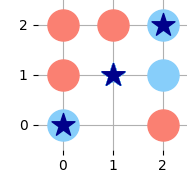

In [9]:
% matplotlib notebook


gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_No_MCTS)


# Training Loop

In [11]:
# initialize our alphazero agent and optimizer
import torch.optim as optim

game=ConnectN(**game_setting)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=1.e-4)

## Tenative exercise:
code up the alphazero loss function, defined to be
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
I added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [12]:
# train our agent

from collections import deque
import MCTS

episodes = 1000 #4000
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

for e in range(episodes):
    mytree = MCTS.Node(ConnectN(**game_setting)) #initialize the top node for MCTS for each episode
    vterm = []
    logterm = []
    
    #during training: for each episode, play the game till completion.
    while mytree.outcome is None:
        for _ in range(50):
            mytree.explore(policy)
            #print(_, mytree.nn_v, mytree.V)

        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next() #update rootnode for next iteration. Note 'v' is not being used anywhere.     
        mytree.detach_mother()

        # solution
        # compute prob* log pi 
        loglist = torch.log(nn_p)*p
        
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))

        '''
        Note: The policy network outputs the value of the current state from the next player's perspective.
        However, node.nn_v is the value of the current state from the current player's perspective.
        Because outcome is from the next player's perspective, node.next() is designed to output nn_v from the 
        next player's perspective -- this way it matches with the outcome which is also from the next player's perspective.

        Note: The game outcome is always from player +1's perspective, regardless of who's playing. 
        Hence, need to multiply nn_v (from node.next()) by current_player (i.e. +1 or -1) to make it always be 
        from player +1's perspective.
        
        Moreover, the value of a game-state can be different for the same game-state depending upon which 
        player is playing. Hence, the input to policy network is game.state*game.player. See process_policy() 
        in MCTS.py for details.
        '''
        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    #Note: this outcome is from the next player's perspective,
    #and that's why nn_v is the value of the current state from the next player's perspective as that's what it's trained to in the loss function
    outcome = mytree.outcome 
    outcomes.append(outcome)
    #print(vterm)
    #print(outcome)    
    
    # solution    
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    
    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
    
timer.finish()

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


game:  50 , mean loss: 5.89 , recent outcomes:  [0, 0, 0, 0, 0, -1, 0, 1, 1, 0]


game:  100 , mean loss: 6.50 , recent outcomes:  [0, 1, 1, 1, 1, 1, 1, 0, 0, -1]


game:  150 , mean loss: 6.61 , recent outcomes:  [1, -1, 1, 0, 0, 1, 0, 1, 0, 1]


game:  200 , mean loss: 7.10 , recent outcomes:  [-1, 0, 1, 1, 0, 1, 0, 1, 0, 1]


game:  250 , mean loss: 7.51 , recent outcomes:  [0, 1, 1, 1, 0, 1, 1, -1, 1, 0]


game:  300 , mean loss: 6.43 , recent outcomes:  [1, -1, -1, 0, 0, 0, 1, -1, 0, 1]


game:  350 , mean loss: 5.32 , recent outcomes:  [0, 1, 0, 1, 1, 0, -1, 0, 0, -1]


game:  400 , mean loss: 6.21 , recent outcomes:  [1, -1, 1, 0, 0, -1, 1, 0, 0, 0]


game:  450 , mean loss: 6.36 , recent outcomes:  [1, 1, 0, 0, 0, -1, 1, 0, 1, 0]


game:  500 , mean loss: 6.00 , recent outcomes:  [-1, 0, 1, 1, -1, 0, 1, 1, 0, 0]


game:  550 , mean loss: 5.24 , recent outcomes:  [0, 0, 1, 1, 0, 0, 1, 1, 1, 1]


game:  600 , mean loss: 4.54 , recent outcomes:  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


game:  650 , mean loss: 4.34 , recent outcomes:  [0, -1, 0, 0, 0, -1, 1, 0, 0, 1]


game:  700 , mean loss: 4.12 , recent outcomes:  [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]


game:  750 , mean loss: 4.37 , recent outcomes:  [0, 0, -1, 0, 0, 0, 0, 0, 0, -1]


game:  800 , mean loss: 3.61 , recent outcomes:  [1, -1, 0, 0, 0, 0, 0, 0, 1, 0]


game:  850 , mean loss: 4.15 , recent outcomes:  [0, 0, 0, 1, 0, 0, 0, -1, 0, -1]


game:  900 , mean loss: 3.53 , recent outcomes:  [0, 0, 0, 0, 0, -1, 0, 0, 0, 1]


game:  950 , mean loss: 3.15 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  1000 , mean loss: 3.74 , recent outcomes:  [0, 0, 0, -1, 0, 0, 0, 1, 1, -1]


<IPython.core.display.Javascript object>


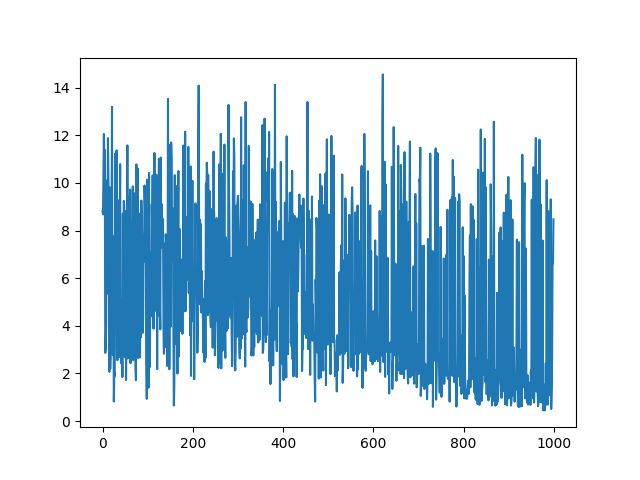

In [13]:
# plot your losses

import matplotlib.pyplot as plt

% matplotlib notebook
plt.plot(losses)
plt.show()


# Play a game against your alphazero agent !

<IPython.core.display.Javascript object>


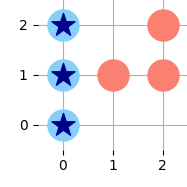

In [17]:
% matplotlib notebook

# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


<IPython.core.display.Javascript object>


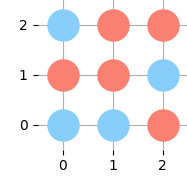

In [18]:
% matplotlib notebook

# as second player

gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)
